# Random Forest Regressor

In [34]:
import pandas as pd
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns  

#ML
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

In [49]:
df = pd.read_csv('C:/Projects/BatteryLevelAnalysis/data/cleaned_data.csv')

In [50]:
df.vin.value_counts()

33daef83a17d84720f7068787af3ff5d3bf481df2eb76c9b1b247ef6c3019d03    2807
34c4bc86529de3dacbbfd001b9fe83c1597db9e62c377cd5d6a5b584e1b4aa6f    2670
4194eb566c3f1b40f25638220a8b8df280221ecade74dbfdab6624ebb76414b8    2636
bd9b605dba9e4ba7c3207c3007464a8791b117354a6b51adb6c15b75e11d1eb4    2586
d4d6d0cadeb1b74f7a674ded3756a270695c0c02e414a95e3e05fb7694d1170b    2565
                                                                    ... 
11d0909a8dc2d787ed0f6cc99d989d29b329d65a8f6ab4c1687ae15e5cf39826       2
0cd5948e0c225c9d1dc14844cf793a62ef7739ffae638b3be3af475c6190bd4e       2
7e34b438bc2e9d15a82aab422212715dc3ef4bf2a8ec7cd363e3950f59020e9b       2
36d04066ae54b02f00c6c932e26c71daf12b860723d1732f642e6a014186fc93       1
f494f6eac8b4194e27bc68afd7066386edac25995341c4c0f517775234d44e9b       1
Name: vin, Length: 8421, dtype: int64

In [51]:
df = df.loc[df.vin == '33daef83a17d84720f7068787af3ff5d3bf481df2eb76c9b1b247ef6c3019d03']

In [5]:
df.head(3)

,Unnamed: 0,id,vin,actual_time,powermode,odometer,ambient_temp,vehicle_speed,balancing_status,min_voltage,min_temp,traction_current,max_voltage,imbalance,traction_voltage,max_temp,inlet_coolant_temp,thermal_manager_mode,outlet_coolant_temp,min_soh,soh,max_soh,cycle,num_cycle
946650,983618,1022357,33daef83a17d84720f7068787af3ff5d3bf481df2eb76c...,2019-03-07 11:23:44.000,keyOut,14734,0.0,0.0,noBalancing,3.799,1.0,0.400,3.820,0.021,411,3.0,10,idle,10,95.0,100.0,95.0,storage,1
946651,983619,1022358,33daef83a17d84720f7068787af3ff5d3bf481df2eb76c...,2019-03-07 11:24:14.000,keyOut,14734,0.0,0.0,noBalancing,3.797,1.0,0.400,3.819,0.022,412,3.0,10,idle,10,95.0,100.0,95.0,storage,1
946652,983620,1022359,33daef83a17d84720f7068787af3ff5d3bf481df2eb76c...,2019-03-07 11:24:44.000,keyOut,14734,0.0,0.0,noBalancing,3.798,1.0,0.375,3.819,0.021,412,3.0,10,idle,10,95.0,100.0,95.0,storage,1


In [56]:
df = df.drop(['vin', 'powermode', 'Unnamed: 0', 'traction_current'], axis=1)

In [57]:
data = df.set_index('actual_time')

In [58]:
data.head(3)

,id,odometer,ambient_temp,vehicle_speed,balancing_status,min_voltage,min_temp,max_voltage,imbalance,traction_voltage,max_temp,inlet_coolant_temp,thermal_manager_mode,outlet_coolant_temp,min_soh,soh,max_soh,cycle,num_cycle
actual_time,,,,,,,,,,,,,,,,,,,
2019-03-07 11:23:44.000,1022357,14734,0.0,0.0,noBalancing,3.799,1.0,3.820,0.021,411,3.0,10,idle,10,95.0,100.0,95.0,storage,1
2019-03-07 11:24:14.000,1022358,14734,0.0,0.0,noBalancing,3.797,1.0,3.819,0.022,412,3.0,10,idle,10,95.0,100.0,95.0,storage,1
2019-03-07 11:24:44.000,1022359,14734,0.0,0.0,noBalancing,3.798,1.0,3.819,0.021,412,3.0,10,idle,10,95.0,100.0,95.0,storage,1


After some additional data cleaning categorical features were encoded. 

In [59]:
bs = data.balancing_status.str.get_dummies()
cy = data.cycle.str.get_dummies()
tmm = data.thermal_manager_mode.str.get_dummies()
data['c_charge'] = cy['charge']
data['c_drive'] = cy['drive']
data['c_storage'] = cy['storage']
data['bs_noBalancing'] = bs['noBalancing']
data['bs_passive'] = bs['passiveBalancing']
data['tmm_activeHeating'] = tmm['activeHeating']
data['tmm_idle'] = tmm['idle']
data = data.drop(columns = ['balancing_status', 'thermal_manager_mode', 'cycle'])

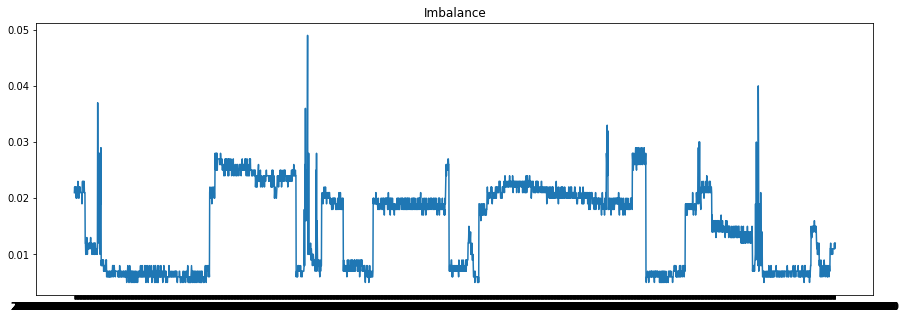

In [41]:
plt.figure(figsize=(15, 5))
plt.plot(data.imbalance)
plt.title('Imbalance')
plt.show()

The lags were created. They start with 8th record (4 minutes) and goes up to the 1 hour with a step of 5 minutes. 

In [60]:
for i in range(10, 120, 8):
    data["lag_{}".format(i)] = data.imbalance.shift(i)

In [61]:
data.tail()

,id,odometer,ambient_temp,vehicle_speed,min_voltage,min_temp,max_voltage,imbalance,traction_voltage,max_temp,inlet_coolant_temp,outlet_coolant_temp,min_soh,soh,max_soh,num_cycle,c_charge,c_drive,c_storage,bs_noBalancing,bs_passive,tmm_activeHeating,tmm_idle,lag_10,lag_18,lag_26,lag_34,lag_42,lag_50,lag_58,lag_66,lag_74,lag_82,lag_90,lag_98,lag_106,lag_114
actual_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-04-02 07:56:38.000,1026133,15875,20.0,0.0,3.573,19.0,3.584,0.011,387,21.0,210,210,95.0,100.0,95.0,27,0,0,1,1,0,0,1,0.011,0.008,0.006,0.007,0.006,0.007,0.010,0.014,0.015,0.013,0.007,0.007,0.006,0.006
2019-04-02 07:57:08.000,1026134,15875,20.0,0.0,3.572,19.0,3.584,0.012,387,21.0,210,210,95.0,100.0,95.0,27,0,0,1,1,0,0,1,0.010,0.007,0.008,0.006,0.007,0.009,0.010,0.012,0.016,0.014,0.006,0.006,0.007,0.006
2019-04-02 07:57:38.000,1026135,15875,20.0,0.0,3.573,19.0,3.584,0.011,387,21.0,210,210,95.0,100.0,95.0,27,0,0,1,1,0,0,1,0.011,0.007,0.006,0.008,0.007,0.007,0.012,0.011,0.015,0.015,0.007,0.007,0.007,0.007
2019-04-02 07:58:08.000,1026136,15875,20.0,0.0,3.572,19.0,3.584,0.012,387,21.0,210,210,95.0,100.0,95.0,27,0,0,1,1,0,0,1,0.011,0.011,0.007,0.008,0.007,0.006,0.008,0.012,0.015,0.014,0.008,0.006,0.007,0.005
2019-04-02 07:58:38.000,1026137,15875,20.0,0.0,3.572,19.0,3.584,0.012,387,21.0,210,210,95.0,100.0,95.0,27,0,0,1,1,0,0,1,0.010,0.011,0.007,0.008,0.008,0.007,0.009,0.010,0.014,0.015,0.008,0.007,0.007,0.008


## Train and Test sets

In this part the dataset was divided on train and test set with test set 30% of the datset. 


In [63]:
def timeseries_train_test_split(X, y, test_size):
   
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [64]:
y = data.dropna().imbalance
X = data.dropna().drop(['imbalance'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [65]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [66]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1885, 36)
(808, 36)
(1885,)
(808,)


## Modeling

### Training 

In [73]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 0)
# Train the model on training data
rf.fit(X_train, y_train);

### Prediction 

In [74]:
predictions = rf.predict(X_test)
errors = abs(predictions - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 4))

Mean Absolute Error: 0.0026


In [75]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 75.1 %.


## Features Importance

In [76]:
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: traction_voltage     Importance: 0.36
Variable: max_voltage          Importance: 0.31
Variable: min_voltage          Importance: 0.25
Variable: id                   Importance: 0.02
Variable: vehicle_speed        Importance: 0.02
Variable: num_cycle            Importance: 0.02
Variable: odometer             Importance: 0.0
Variable: ambient_temp         Importance: 0.0
Variable: min_temp             Importance: 0.0
Variable: max_temp             Importance: 0.0
Variable: inlet_coolant_temp   Importance: 0.0
Variable: outlet_coolant_temp  Importance: 0.0
Variable: min_soh              Importance: 0.0
Variable: soh                  Importance: 0.0
Variable: max_soh              Importance: 0.0
Variable: c_charge             Importance: 0.0
Variable: c_drive              Importance: 0.0
Variable: c_storage            Importance: 0.0
Variable: bs_noBalancing       Importance: 0.0
Variable: bs_passive           Importance: 0.0
Variable: tmm_activeHeating    Importance: 0.0
Variabl

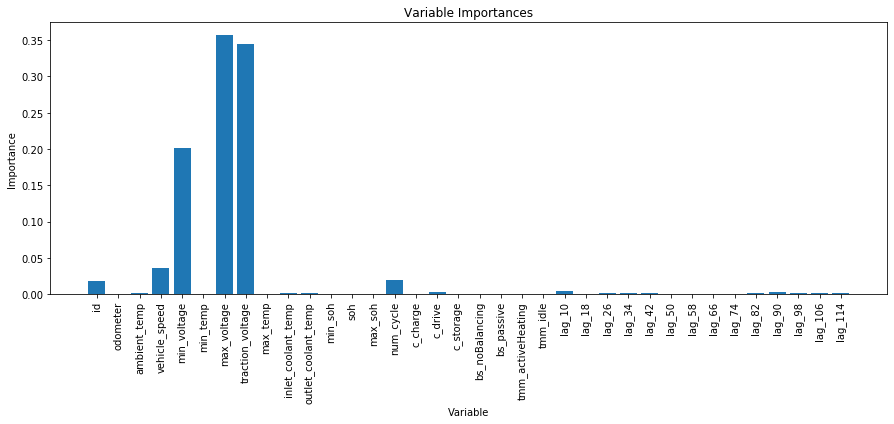

In [71]:
x_values = list(range(len(importances)))
plt.figure(figsize=(15, 5))
plt.bar(x_values, importances)
plt.xticks(x_values, X, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

The biggest impact has lag_10, because it is the closest lag to the predictied value. Interestingly, the graph above shows that imbalance has significant influence on the min_voltage (18%). 

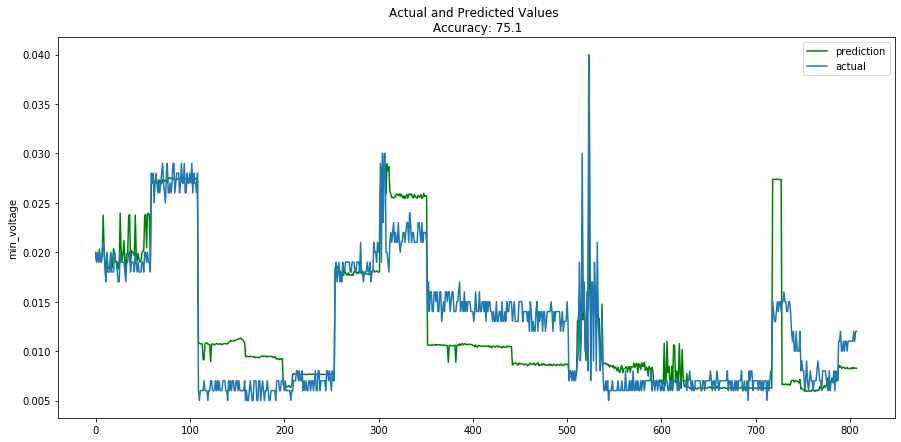

In [81]:
prediction = rf.predict(X_test)
    
plt.figure(figsize=(15, 7))
plt.plot(prediction, "g", label='prediction')
plt.plot(y_test.values, label='actual')
plt.legend()
mape = np.mean(100 * (errors / y_test))
accuracy = 100 - mape
plt.ylabel('min_voltage'); plt.title('Actual and Predicted Values \n Accuracy: {}'.format(round(accuracy, 2)));

## Results

The prediction of the min_voltage with RFR showed on the plot above. Segments in the first part of the data have low residuals. However, the algorithm did not handle unusual behaviour of the vehicle. This can happen because RF has difficulties with extrapolation. 